In [1]:
from evaluate import evaluate, uniform_distribution, majority_distribution, get_gt_answers, process_csv, earth_movers_distance, get_demographic_partitions
import os
import numpy as np
import matplotlib.pyplot as plt
import math

/Users/demon702/Desktop/Sem3/ai2/value_alignment/evaluation/evaluate.py:20: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  full_demographic_df = pd.read_csv(f'{DATASET_DIR}/full/full_demographic_qa.tsv', sep='\t', index_col='D_INTERVIEW')


## Load model outputs

In [2]:
MODEL_OUTPUT_FILES_DIR = 'model_outputs'
THRESHOLDS = np.arange(0, 0.45, 0.05)

model_to_output_file = {
    'Alpaca (7B)': 'alpaca.tsv',
    'Alpaca (7B)$_{dem}$': 'alpaca_with_demographics.tsv',
    'Vicuna v1.5 (7B)': 'vicuna.tsv',
    'Vicuna v1.5 (7B)$_{dem}$': 'vicuna_with_demographics.tsv',
    'Mixtral-8x7B Instruct': 'mixtral.tsv',
    'Mixtral-8x7B Instruct$_{dem}$': 'mixtral_with_demographics.tsv',
    'GPT-3.5 Turbo': 'gpt-3.5.tsv',
    'GPT-3.5 Turbo$_{dem}$': 'gpt-3.5_with_demographics.tsv'
}

model_to_df = { model_name: process_csv(os.path.join(MODEL_OUTPUT_FILES_DIR, model_output_file), sep='\t') for model_name , model_output_file in model_to_output_file.items() }

Processing model_outputs/alpaca.tsv
No of valid scores 8183
Processing model_outputs/alpaca_with_demographics.tsv
No of valid scores 8274
Processing model_outputs/vicuna.tsv
No of valid scores 8280
Processing model_outputs/vicuna_with_demographics.tsv
No of valid scores 8192
Processing model_outputs/mixtral.tsv
No of valid scores 8278
Processing model_outputs/mixtral_with_demographics.tsv
No of valid scores 8263
Processing model_outputs/gpt-3.5.tsv
No of valid scores 8280
Processing model_outputs/gpt-3.5_with_demographics.tsv
No of valid scores 8277


## Load baselines

In [3]:
def get_baseline_distributions(model_df, questions):


    # Get the ground truth answers for each question
    ground_truth_answers = { q: get_gt_answers(q, model_df, normalize=True) for q in questions }

    # Extract the uniform disribution for each question
    uniform_dist = { q: uniform_distribution(q, normalize=True) for q in questions }

    # Calculate the Earth Mover's distance for the uniform distrubution of each question                      
    uniform_dist_emd = { q: earth_movers_distance(ground_truth_answers[q], dist) for q, dist in uniform_dist.items() }


    # Extract the majority disribution for each question
    majority_dist = { q: majority_distribution(gt_answers) for q, gt_answers in ground_truth_answers.items() }


    # Calculate the Earth Mover's distance for the majority distrubution of each question                      
    majority_dist_emd = { q: earth_movers_distance(ground_truth_answers[q], dist) for q, dist in majority_dist.items() }
    return uniform_dist_emd, majority_dist_emd


## Plot setup

In [14]:

# Setup plot style
MARKER_MAPPING = {
    'Uniform': None,
    'Majority': None,
    'Alpaca (7B)': 'x',
    'Alpaca (7B)$_{dem}$': 'x',
    'Vicuna v1.5 (7B)': '^',
    'Vicuna v1.5 (7B)$_{dem}$': '^',
    'Mixtral-8x7B Instruct': 's',
    'Mixtral-8x7B Instruct$_{dem}$': 's',
    'GPT-3.5 Turbo': 'o',
    'GPT-3.5 Turbo$_{dem}$': 'o'
}

COLOR_MAPPING = {
    'Uniform': 'black',
    'Majority': 'orange',
    'Alpaca (7B)': 'purple',
    'Alpaca (7B)$_{dem}$': 'purple',
    'Vicuna v1.5 (7B)': 'blue',
    'Vicuna v1.5 (7B)$_{dem}$': 'blue',
    'Mixtral-8x7B Instruct': 'red',
    'Mixtral-8x7B Instruct$_{dem}$': 'red',
    'GPT-3.5 Turbo': 'green',
    'GPT-3.5 Turbo$_{dem}$': 'green'
}

DEMOGRAPHY_LINE_STYLE = '-'
NON_DEMOGRAPHY_LINE_STYLE = (0, (5, 3))

LINESTYLE_MAPPING = {
    'Uniform': 'dotted',
    'Majority': 'dashdot',
    'Alpaca (7B)': NON_DEMOGRAPHY_LINE_STYLE,
    'Alpaca (7B)$_{dem}$': DEMOGRAPHY_LINE_STYLE,
    'Vicuna v1.5 (7B)': NON_DEMOGRAPHY_LINE_STYLE,
    'Vicuna v1.5 (7B)$_{dem}$': DEMOGRAPHY_LINE_STYLE,
    'Mixtral-8x7B Instruct': NON_DEMOGRAPHY_LINE_STYLE,
    'Mixtral-8x7B Instruct$_{dem}$': DEMOGRAPHY_LINE_STYLE,
    'GPT-3.5 Turbo': NON_DEMOGRAPHY_LINE_STYLE,
    'GPT-3.5 Turbo$_{dem}$': DEMOGRAPHY_LINE_STYLE
}


In [15]:
# Plot threshold vs percentage of questions with emd (Earth Mover's Distance) under that threshold for one baseline or model
def plot_emd(model_name, model_emds, questions, ax):
    emd_array = np.array(list(model_emds.values()))
    percentage_questions_under_threshold = [((emd_array <= th).sum() * 100) / len(questions) for th in THRESHOLDS]
    ax.plot(
        THRESHOLDS,
        percentage_questions_under_threshold,
        label=model_name,
        linewidth=1,
        color=COLOR_MAPPING[model_name],
        linestyle=LINESTYLE_MAPPING[model_name],
        markersize=5,
        marker=MARKER_MAPPING[model_name]
    )
    
# Plot baselines and models
def plot_models_and_baselines(model_to_df, ax=None, title='Overall'):
    if not ax:
        ax = plt.gca()
    model_to_emd = { model_name: evaluate(model_df) for model_name, model_df in model_to_df.items() }
    
    # Pick one model dataframe
    model_df = list(model_to_df.values())[0]
    
    # Get the list of questions present in the model output files
    questions = list(list(model_to_emd.values())[0].keys())
    
    # Get uniform and majority baselines
    uniform_dist_emd, majority_dist_emd = get_baseline_distributions(model_df, questions)
    
    plot_emd('Uniform', uniform_dist_emd, questions, ax)
    plot_emd('Majority', majority_dist_emd, questions, ax)

    for model_name, model_emd in model_to_emd.items():
        plot_emd(model_name, model_emd, questions, ax)

    ax.set_title(title, fontsize=15, fontweight='bold')
    ax.set_xlabel('Threshold', fontsize=15)
    ax.set_ylabel('Percentage', fontsize=15)



## Plot and compare different models

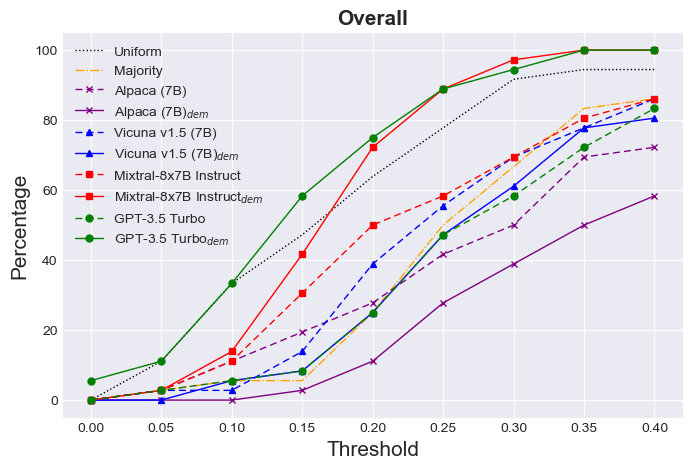

In [16]:
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(8, 5))
plot_models_and_baselines(model_to_df)
plt.legend(loc='best')
plt.show()

## Plot demographic partitions

In [11]:
def plot_demographic_partitions(model_to_df, demographic_col):
    partitions = get_demographic_partitions(model_to_df, demographic_col)
    fig, axs = plt.subplots(math.ceil((len(partitions) + 1) / 3), 3, figsize=(12, 4))
    axs = axs.ravel()
    
    plot_models_and_baselines(model_to_df, axs[0], 'Overall')
    
    for idx, (partition_attr, partition_model_to_df) in enumerate(partitions.items()):
        plot_models_and_baselines(partition_model_to_df, axs[idx + 1], partition_attr)
        
    lines, labels = axs[0].get_legend_handles_labels()
    fig.legend(lines, labels, loc='upper center', ncol=5, fontsize=12)
    plt.tight_layout(rect=[0.00, 0.00, 1.0, 0.89])

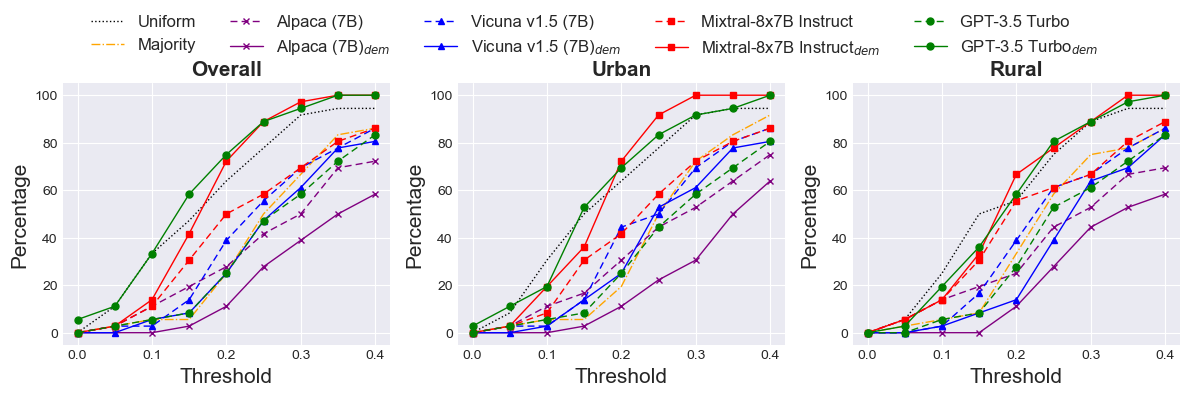

In [12]:
plt.style.use('seaborn-darkgrid')
plot_demographic_partitions(model_to_df, 'H_URBRURAL')
plt.show()